# Machine learning of fluid flows using the proper orthogonal decomposition (POD) and the dynamic mode decomposition (DMD) methods

### Import Libraries and Load Data

In [1]:
# Import required libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from numpy.linalg import svd, pinv, eig
from scipy.stats import pearsonr

In [2]:
# Load the pre-saved U_data.h5 file
with h5py.File("U_data.h5", "r") as f:
    dataset_name = list(f.keys())[0]
    U = np.array(f[dataset_name])

print(f"Loaded data shape: {U.shape}")

Loaded data shape: (147456, 1052)


### Proper Orthogonal Decomposition (POD)

In [3]:
# Center the data
U_mean = np.mean(U, axis=1, keepdims=True)
U_centered = U - U_mean

In [4]:
r = 10 # Number of modes
energy_threshold = 0.99 # 99% of total energy
required_m = None
m_values = np.linspace(50, U_centered.shape[1], num=20, dtype=int)
for m in m_values:
    U_m = U_centered[:, :m]
    U_m_U, U_m_S, U_m_VT = randomized_svd(U_m, n_components=10, random_state=0)
    cumulative_energy = np.cumsum(U_m_S**2) / np.sum(U_m_S**2)
    energy_r = cumulative_energy[-1]
    if energy_r >= energy_threshold and required_m is None:
        required_m = m

print(f"Required number of snapshots for convergence (99% energy): {required_m}")

Required number of snapshots for convergence (99% energy): 50


In [5]:
# Compute the full SVD (randomized SVD could be used to reduce computation time)
Phi, Sigma, PsiT = svd(U_centered, full_matrices=0)

# Energy captured by the singular values
energy = np.cumsum(Sigma**2) / np.sum(Sigma**2)

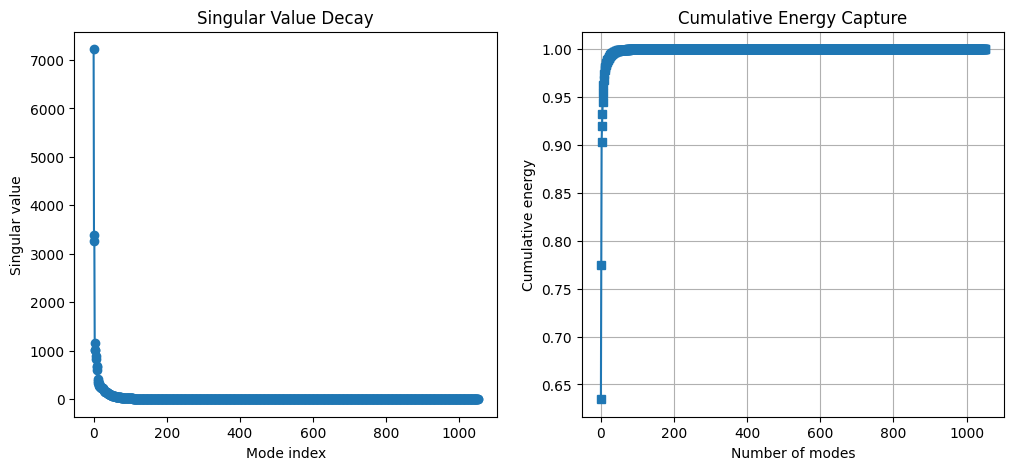

In [6]:
# Plot singular value decay and cumulative energy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(Sigma, 'o-')
plt.xlabel('Mode index')
plt.ylabel('Singular value')
plt.title('Singular Value Decay')

plt.subplot(1,2,2)
plt.plot(energy, 's-')
plt.xlabel('Number of modes')
plt.ylabel('Cumulative energy')
plt.title('Cumulative Energy Capture')
plt.grid(True)
plt.show()

# Extract the top r POD modes
POD_modes = Phi[:, :r]

### Dynamic Mode Decomposition (DMD)

In [7]:
# Split data into two matrices: U1 (all snapshots except last) and U2 (all snapshots except first)
U1 = U_centered[:, :-1]
U2 = U_centered[:, 1:]

# SVD of U1 for the reduced-order representation
U1_U, U1_S, U1_VT = svd(U1, full_matrices=0)
r_dmd = r # Same number of modes from the previous part
U1_U_r = U1_U[:, :r_dmd]
U1_S_r = np.diag(U1_S[:r_dmd])
U1_V_r = U1_VT[:r_dmd, :]

# Compute the low-dimensional linear map A_tilde
A_tilde = U1_U_r.T @ U2 @ U1_V_r.T @ pinv(U1_S_r)

# Eigen decomposition of A_tilde
eigs, W = eig(A_tilde)
omega = np.log(eigs) / 0.125 # Time steps of 0.125 seconds

# Compute DMD modes in the original high-dimensional space
DMD_modes = U2 @ U1_V_r.T @ pinv(U1_S_r) @ W

In [8]:
# Sort eigenvalues and print
print(f"DMD Eigenvalues: {eigs}")

DMD Eigenvalues: [0.005635  +0.0477848j  0.005635  -0.0477848j  0.87951649+0.47681151j
 0.87951649-0.47681151j 0.94722225+0.31747339j 0.94722225-0.31747339j
 0.98815867+0.12737092j 0.98815867-0.12737092j 0.98680254+0.16471149j
 0.98680254-0.16471149j]


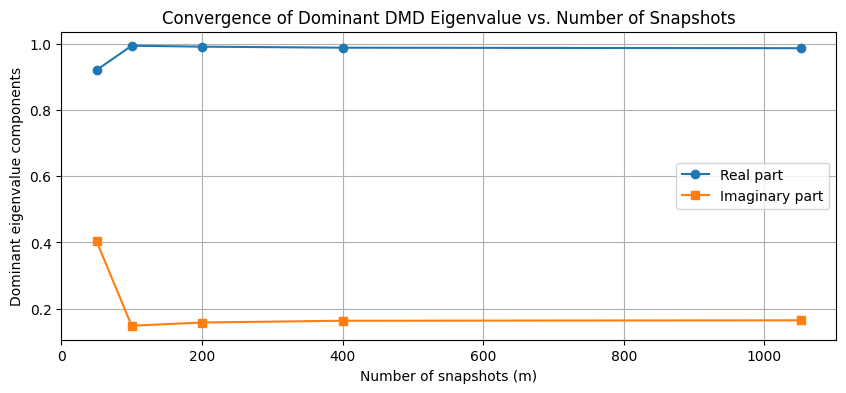

In [10]:
m_values = [50, 100, 200, 400, U_centered.shape[1]]
dominant_eigs = []

for m in m_values:
    U1_m = U_centered[:, :m-1]
    U2_m = U_centered[:, 1:m]
    
    # Perform SVD on U1_m
    U1_U_m, U1_S_m, U1_VT_m = svd(U1_m, full_matrices=False)
    U1_U_r_m = U1_U_m[:, :r_dmd]
    U1_S_r_m = np.diag(U1_S_m[:r_dmd])
    U1_V_r_m = U1_VT_m[:r_dmd, :]
    A_tilde_m = U1_U_r_m.T @ U2_m @ U1_V_r_m.T @ pinv(U1_S_r_m)
    eigs_m, _ = eig(A_tilde_m)
    
    # Choose the dominant eigenvalue
    dominant = eigs_m[np.argmax(np.abs(eigs_m))]
    dominant_eigs.append(dominant)

dominant_eigs = np.array(dominant_eigs)

# Plot convergence of the dominant DMD eigenvalue
plt.figure(figsize=(10,4))
plt.plot(m_values, dominant_eigs.real, 'o-', label='Real part')
plt.plot(m_values, dominant_eigs.imag, 's-', label='Imaginary part')
plt.xlabel('Number of snapshots (m)')
plt.ylabel('Dominant eigenvalue components')
plt.title('Convergence of Dominant DMD Eigenvalue vs. Number of Snapshots')
plt.legend()
plt.grid(True)
plt.show()


### Visualization of Modes

In [11]:
nx, ny = 768, 192 # Spatial dimensions

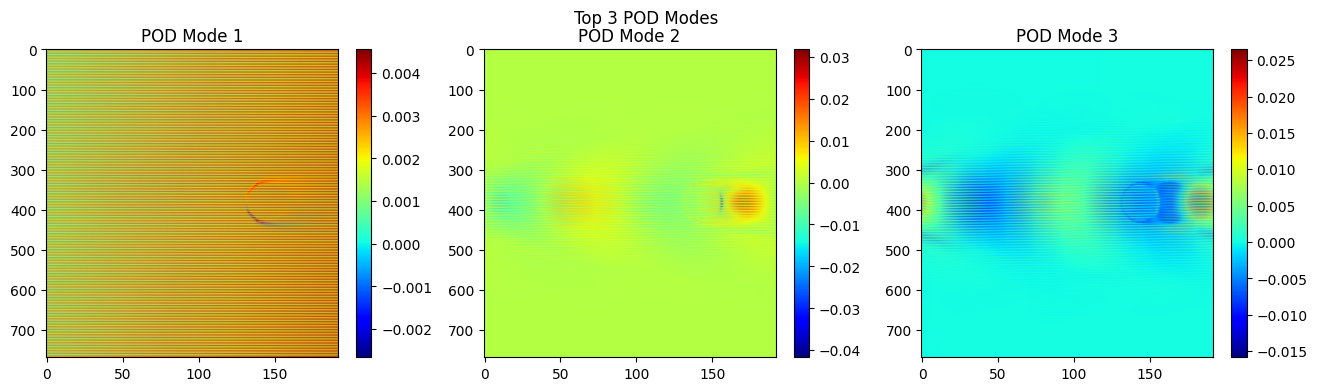

In [12]:
# Visualize first few POD modes
plt.figure(figsize=(16, 4))
for i in range(3):
    mode_reshaped = POD_modes[:, i].reshape((nx, ny))
    plt.subplot(1, 3, i+1)
    plt.imshow(mode_reshaped, cmap='jet', aspect='auto')
    plt.title(f'POD Mode {i+1}')
    plt.colorbar()
plt.suptitle('Top 3 POD Modes')
plt.show()

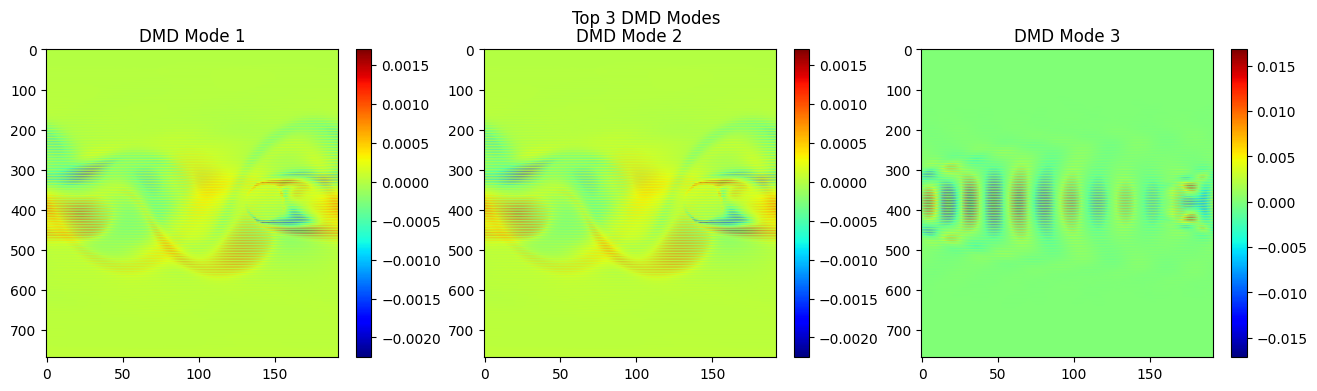

In [13]:
# Visualize first few DMD modes
plt.figure(figsize=(16, 4))
for i in range(3):
    mode_reshaped = np.real(DMD_modes[:, i]).reshape((nx, ny))
    plt.subplot(1, 3, i+1)
    plt.imshow(mode_reshaped, cmap='jet', aspect='auto')
    plt.title(f'DMD Mode {i+1}')
    plt.colorbar()
plt.suptitle('Top 3 DMD Modes')
plt.show()

### Prediction Performance

In [14]:
# Prediction using DMD
u0 = U_centered[:, 0]
b = pinv(DMD_modes) @ u0

# Define prediction time points
M_pred = U.shape[1]
t = np.arange(0, M_pred) * 0.125

# Reconstruct the solution using DMD
u_dmd = np.zeros((U_centered.shape[0], M_pred), dtype=complex)
for i, time in enumerate(t):
    u_dmd[:, i] = DMD_modes @ (b * np.exp(omega * time))

# Add back the mean if data was centered
u_dmd_full = np.real(u_dmd) + U_mean

In [19]:
# Compute Pearson's correlation for validation
snapshot_index = 50
actual = U[:, snapshot_index]
predicted = u_dmd_full[:, snapshot_index]

corr, _ = pearsonr(actual, predicted)
print(f"Pearson Correlation (snapshot {snapshot_index}): {corr:.4f}")

Pearson Correlation (snapshot 50): 0.5717


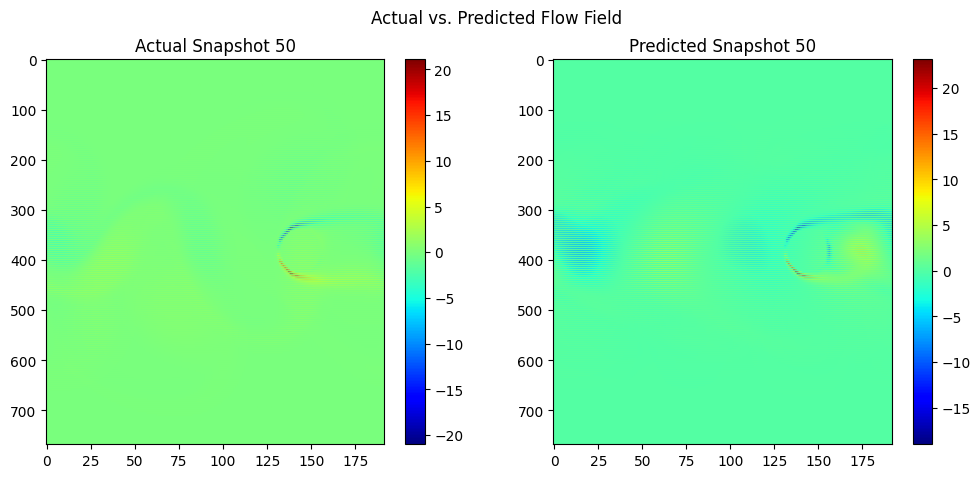

In [20]:
# Plot actual vs. predicted for a given snapshot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(actual.reshape((nx, ny)), cmap='jet', aspect='auto')
plt.title(f'Actual Snapshot {snapshot_index}')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(predicted.reshape((nx, ny)), cmap='jet', aspect='auto')
plt.title(f'Predicted Snapshot {snapshot_index}')
plt.colorbar()
plt.suptitle('Actual vs. Predicted Flow Field')
plt.show()

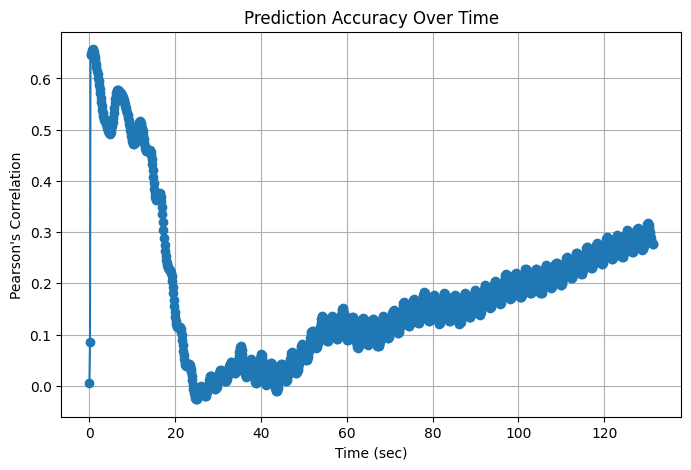

In [21]:
# Plot the evolution of Pearson's correlation over time for validation
correlations = []
for i in range(M_pred):
    corr_val, _ = pearsonr(U[:, i], u_dmd_full[:, i])
    correlations.append(corr_val)

plt.figure(figsize=(8,5))
plt.plot(t, correlations, 'o-')
plt.xlabel('Time (sec)')
plt.ylabel("Pearson's Correlation")
plt.title('Prediction Accuracy Over Time')
plt.grid(True)
plt.show()

In [22]:
# Calculate prediction errors for each snapshot
errors = U - u_dmd_full
error_flat = errors.flatten()

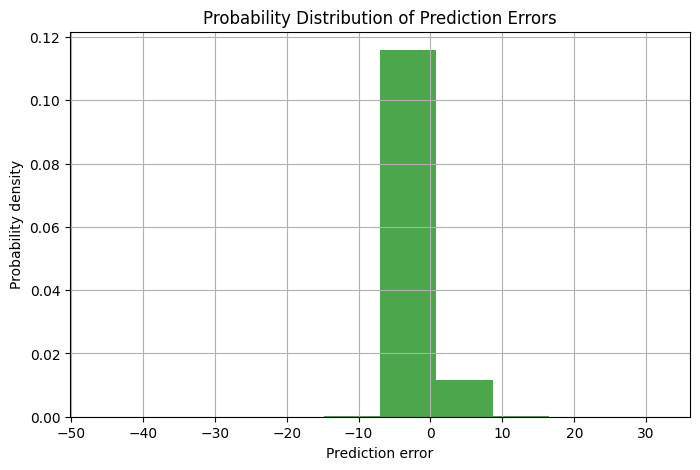

In [23]:
# Plot the probability distribution of prediction errors
plt.figure(figsize=(8,5))
plt.hist(error_flat, bins=10, density=True, alpha=0.7, color='g')
plt.xlabel('Prediction error')
plt.ylabel('Probability density')
plt.title('Probability Distribution of Prediction Errors')
plt.grid(True)
plt.show()